# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch/Layer Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
# eval_numerical_gradient is used for the last layer (without upstream deritive "dout")
# eval_numerical_gradient_array is used for hidden layer (with "dout")
## eval_numerical_gradient can also be used for any hidden layer as long as model.loss function is used
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [6]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1: 

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
Sigmoid and ReLU would have the problem of "gradient vanishing", getting zero gredient. Leaky ReLU could overcome this drawback.
Circumstance with "gradient vanishing" problem:
- for Sigmoid, when $abs(input)$ is extremly large
- for ReLU, when input is less then zero


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [7]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [8]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. **This class will serve as a model for the other networks you will implement in this assignment**, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [9]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.12e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 7.98e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [10]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

## configuration
num_train = data['X_train'].shape[0]
num_val = data['X_val'].shape[0]
kwargs = {'update_rule':'adam', 'lr_decay':0.95, 'batch_size':200, 
         'num_epochs':50, 'num_train_samples':num_train, 
          'num_val_samples':num_val, 'print_every':1000, 
         'verbose':True}

# create Solver instance
solver = Solver(model, data, **kwargs)
solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Epoch 0 / 50) train acc: 0.172327; val_acc: 0.163000
(Epoch 1 / 50) train acc: 0.406469; val_acc: 0.399000
(Epoch 2 / 50) train acc: 0.430776; val_acc: 0.430000
(Epoch 3 / 50) train acc: 0.434449; val_acc: 0.401000
(Epoch 4 / 50) train acc: 0.477837; val_acc: 0.444000
(Iteration 1000 / 12250) loss: 1.479563
(Epoch 5 / 50) train acc: 0.492408; val_acc: 0.458000
(Epoch 6 / 50) train acc: 0.498408; val_acc: 0.453000
(Epoch 7 / 50) train acc: 0.523367; val_acc: 0.457000
(Epoch 8 / 50) train acc: 0.509837; val_acc: 0.436000
(Iteration 2000 / 12250) loss: 1.385103
(Epoch 9 / 50) train acc: 0.535286; val_acc: 0.460000
(Epoch 10 / 50) train acc: 0.547653; val_acc: 0.468000
(Epoch 11 / 50) train acc: 0.569306; val_acc: 0.483000
(Epoch 12 / 50) train acc: 0.587796; val_acc: 0.493000
(Iteration 3000 / 12250) loss: 1.215753
(Epoch 13 / 50) train acc: 0.581857; val_acc: 0.484000
(Epoch 14 / 50) train acc: 0.587041; val_acc: 0.448000
(Epoch 15 / 50) train acc: 0.591367; val_acc: 0.463000
(Epoch 16 

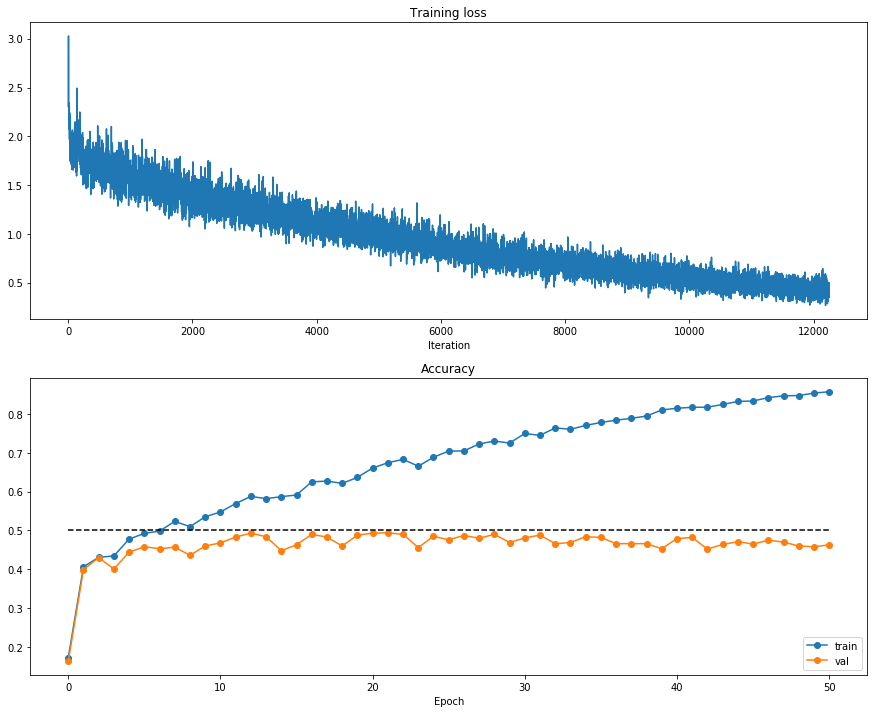

In [11]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history)
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch/layer normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [12]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 1.14e-08
W2 relative error: 6.87e-08
W3 relative error: 3.48e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.108000
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.127000
(Epoch 2 / 20) train acc: 0.440000; val_acc: 0.172000
(Epoch 3 / 20) train acc: 0.500000; val_acc: 0.184000
(Epoch 4 / 20) train acc: 0.540000; val_acc: 0.181000
(Iteration 10 / 40) loss: 1.649552
(Epoch 5 / 20) train acc: 0.740000; val_acc: 0.190000
(Epoch 6 / 20) train acc: 0.740000; val_acc: 0.187000
(Epoch 7 / 20) train acc: 0.740000; val_acc: 0.183000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.177000
(Epoch 9 / 20) train acc: 0.860000; val_acc: 0.200000
(Iteration 20 / 40) loss: 0.515392
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.191000
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.189000
(Epoch 12 / 20) train acc: 0.940000; val_acc: 0.180000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.199000
(Iteration 30 / 40) loss: 0.062867
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.195000
(Epoch 16 / 20) train acc

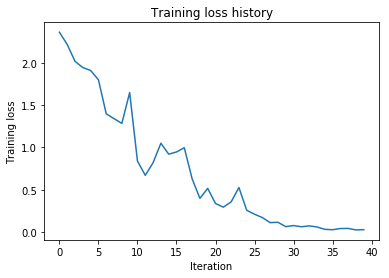

In [13]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

# weight_scale = 1e-2   # Experiment with this!
# learning_rate = 1e-4  # Experiment with this!
weight_scale = 1e-2   # Experiment with this!
learning_rate = 1e-2  # Experiment with this!
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.116000
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.083000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.104000
(Epoch 3 / 20) train acc: 0.520000; val_acc: 0.106000
(Epoch 4 / 20) train acc: 0.700000; val_acc: 0.131000
(Iteration 10 / 40) loss: 6.303601
(Epoch 5 / 20) train acc: 0.700000; val_acc: 0.116000
(Epoch 6 / 20) train acc: 0.840000; val_acc: 0.114000
(Epoch 7 / 20) train acc: 0.880000; val_acc: 0.108000
(Epoch 8 / 20) train acc: 0.900000; val_acc: 0.109000
(Epoch 9 / 20) train acc: 0.960000; val_acc: 0.114000
(Iteration 20 / 40) loss: 0.412498
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.127000
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.126000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.124000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.124000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.124000
(Iteration 30 / 40) loss: 0.001214
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.125000
(Epoch 16 / 20) train acc

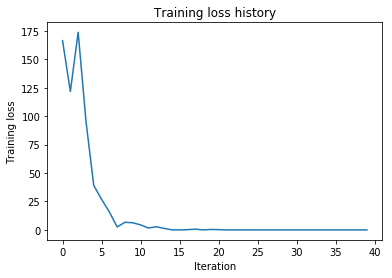

In [14]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

# learning_rate = 2e-3  # Experiment with this!
# weight_scale = 1e-5   # Experiment with this!
learning_rate = 1e-3  # Experiment with this!
weight_scale = 1e-1   # Experiment with this!

model = FullyConnectedNet([100, 100, 100, 100],
                        weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                        print_every=10, num_epochs=20, batch_size=25,
                        update_rule='sgd',
                        optim_config={'learning_rate': learning_rate}, verbose=True)
solver.train()

plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

## Inline Question 2: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
Five-layer net is more sensitive to parameters initialization.
With the increase of layers, the network get deeper, meaning that small changes in the upper stream may result in great changes in output of the network.


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [15]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Epoch 0 / 5) train acc: 0.104000; val_acc: 0.107000
(Iteration 10 / 200) loss: 2.339945
(Iteration 20 / 200) loss: 2.175808
(Iteration 30 / 200) loss: 2.173179
(Iteration 40 / 200) loss: 2.221346
(Epoch 1 / 5) train acc: 0.225000; val_acc: 0.193000
(Iteration 50 / 200) loss: 2.093417
(Iteration 60 / 200) loss: 2.130112
(Iteration 70 / 200) loss: 2.011221
(Iteration 80 / 200) loss: 2.069395
(Epoch 2 / 5) train acc: 0.298000; val_acc: 0.260000
(Iteration 90 / 200) loss: 2.074002
(Iteration 100 / 200) loss: 1.978666
(Iteration 110 / 200) loss: 1.891036
(Iteration 120 / 200) loss: 1.776107
(Epoch 3 / 5) train acc: 0.343000; val_acc: 0.287000
(Iteration 130 / 200) loss: 1.945692
(Iteration 140 / 200) loss: 1.839291
(Iteration 150 / 200) loss: 1.743849
(Iteration 160 / 200) loss: 1.714818
(Epoch 4 / 5) train acc: 0.322000; val_acc: 0.305000
(Iteration 170 / 200) loss: 1.793649
(Iteration 180 / 200) loss: 1.859658
(Iteration 190 / 200) loss: 1.800073
(Iteration 200 / 200) l

/home/vincent/anaconda3/envs/cs231n_2/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


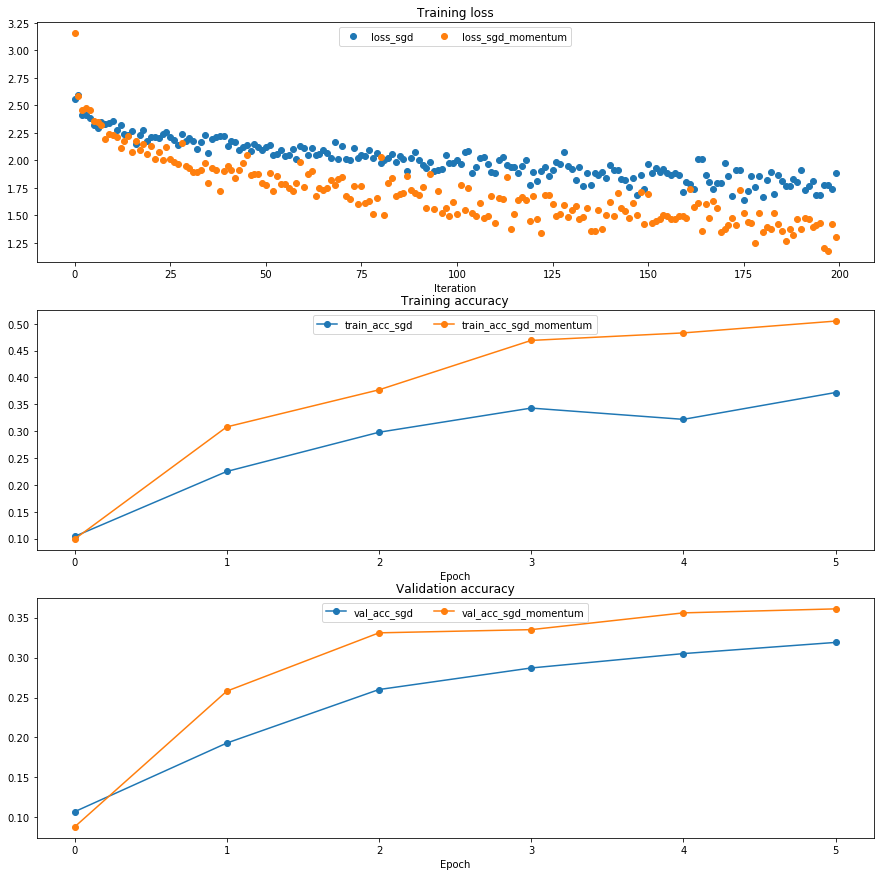

In [16]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [17]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [18]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
(Epoch 0 / 5) train acc: 0.126000; val_acc: 0.110000
(Iteration 10 / 200) loss: 1.988385
(Iteration 20 / 200) loss: 1.927173
(Iteration 30 / 200) loss: 1.834488
(Iteration 40 / 200) loss: 1.711647
(Epoch 1 / 5) train acc: 0.363000; val_acc: 0.330000
(Iteration 50 / 200) loss: 1.709190
(Iteration 60 / 200) loss: 1.654181
(Iteration 70 / 200) loss: 1.592772
(Iteration 80 / 200) loss: 1.780636
(Epoch 2 / 5) train acc: 0.416000; val_acc: 0.362000
(Iteration 90 / 200) loss: 1.344151
(Iteration 100 / 200) loss: 1.469709
(Iteration 110 / 200) loss: 1.324871
(Iteration 120 / 200) loss: 1.193847
(Epoch 3 / 5) train acc: 0.496000; val_acc: 0.374000
(Iteration 130 / 200) loss: 1.509649
(Iteration 140 / 200) loss: 1.423628
(Iteration 150 / 200) loss: 1.247283
(Iteration 160 / 200) loss: 1.133567
(Epoch 4 / 5) train acc: 0.512000; val_acc: 0.345000
(Iteration 170 / 200) loss: 1.233204
(Iteration 180 / 200) loss: 1.317085
(Iteration 190 / 200) loss: 1.349817
(Iteration 200 / 200) 

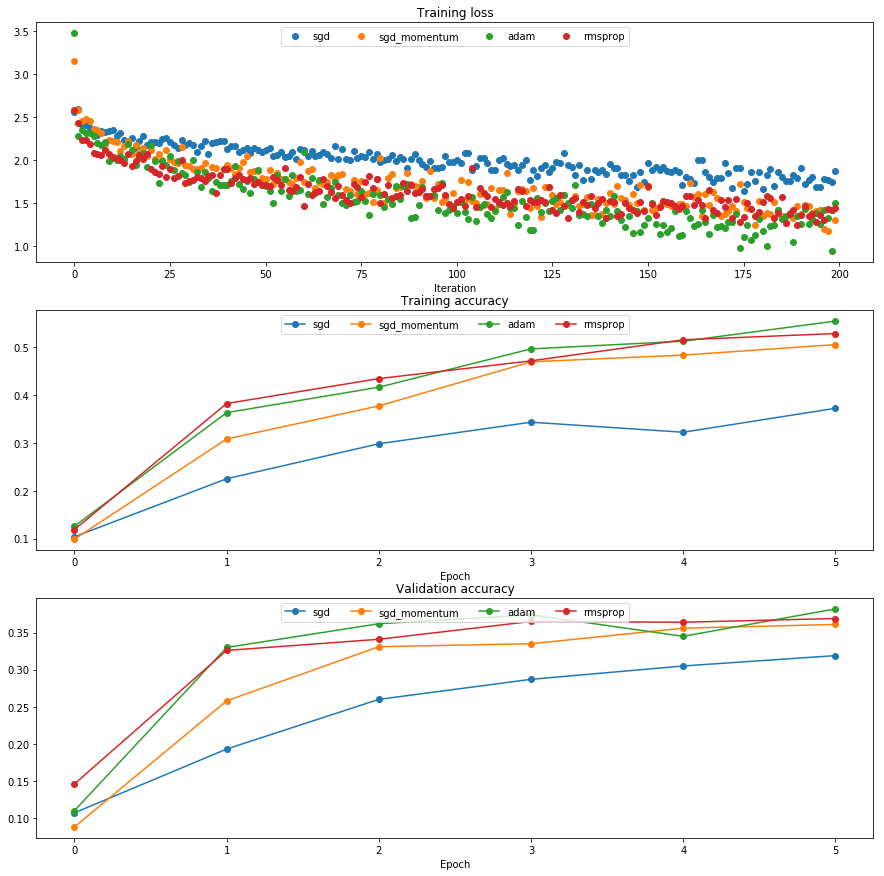

In [19]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 3:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer: 
"cache" is accumulated dw\**2, with the training process goes on, "cache" get larger, therefore, the weights update is too small.

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [35]:
# hyperparameters tunning 1: coarse searching

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_hidden = np.arange(5,10,5)  # fixed at 5 layers
dropout = np.arange(0.1, 1, 0.1) 
normalization = ['batchnorm']  # fixed at batchnorm
weight_scale = 1/10**np.arange(9,1,-1)
learning_rate = 1/10**np.arange(7,1,-1)
regularization = np.append(1/10**np.arange(6,0,-1), np.arange(10,100,20))
print('parameters tunning:')
print('num_hidden: ' , num_hidden)
print('weight_scale: ', weight_scale)
print('learning_rate: ', learning_rate)
print('regularization: ', regularization)


best_val_acc = 0
best_params = {}
total_tests = len(num_hidden) * len(dropout) * len(normalization) * len(
    weight_scale) * len(learning_rate) * len(regularization)
test_count = 0

for i in num_hidden:
    hidden_dims = list(np.repeat(100, i))
    for i_drop in dropout:
        for i_scale in weight_scale:
            for i_lr in learning_rate:
                for i_reg in regularization:
                    for i_norm in normalization:
                        model = FullyConnectedNet(hidden_dims, dropout=i_drop, normalization=i_norm, 
                          weight_scale=i_scale, dtype=np.float64)
                        solver = Solver(model, data, print_every=1000, num_epochs=10, batch_size=200,
                                        update_rule='adam', optim_config={'learning_rate': i_lr}, verbose=False)
                        solver.train()
                        
                        model_best_val_acc = solver.best_val_acc
                        test_count += 1
                        print('(test %d/%d) ------------------------------------' % (test_count, total_tests))
                        print('layer dimension: ', hidden_dims)
                        print('normalization: ', i_norm)
                        print('dropout: %f weight_init_scale: %e lr: %e reg: %e' % (i_drop, i_scale, i_lr, i_reg))
                        print('best val_acc of model: %f' % model_best_val_acc)
                        print('best val_acc of the best model: %f' % best_val_acc)
                        print()
                        if model_best_val_acc > best_val_acc:
                            best_val_acc = model_best_val_acc
                            best_setting = (hidden_dims.copy(), i_drop, i_scale, i_lr, i_reg, i_norm)
                            best_params = solver.best_params
                            best_bn_param = model.bn_params
                            
# save best model
hidden_dims, drop, scale, lr, reg, norm = best_setting
best_model = FullyConnectedNet(hidden_dims, dropout=drop, normalization=norm, 
                          weight_scale=scale, dtype=np.float64)
best_model.params = best_params
best_model.bn_params = best_bn_param

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

parameters tunning:
num_hidden:  [5]
weight_scale:  [1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02]
learning_rate:  [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02]
regularization:  [1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+01 3.e+01 5.e+01 7.e+01
 9.e+01]
(test 1/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-09 lr: 1.000000e-07 reg: 1.000000e-06
best val_acc of model: 0.087000
best val_acc of the best model: 0.000000

(test 2/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-09 lr: 1.000000e-07 reg: 1.000000e-05
best val_acc of model: 0.116000
best val_acc of the best model: 0.087000

(test 3/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-09 lr

(test 30/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-09 lr: 1.000000e-05 reg: 3.000000e+01
best val_acc of model: 0.096000
best val_acc of the best model: 0.145000

(test 31/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-09 lr: 1.000000e-05 reg: 5.000000e+01
best val_acc of model: 0.111000
best val_acc of the best model: 0.145000

(test 32/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-09 lr: 1.000000e-05 reg: 7.000000e+01
best val_acc of model: 0.108000
best val_acc of the best model: 0.145000

(test 33/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale

(test 60/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-09 lr: 1.000000e-02 reg: 1.000000e-02
best val_acc of model: 0.189000
best val_acc of the best model: 0.191000

(test 61/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-09 lr: 1.000000e-02 reg: 1.000000e-01
best val_acc of model: 0.184000
best val_acc of the best model: 0.191000

(test 62/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-09 lr: 1.000000e-02 reg: 1.000000e+01
best val_acc of model: 0.133000
best val_acc of the best model: 0.191000

(test 63/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale

(test 90/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-08 lr: 1.000000e-05 reg: 1.000000e-05
best val_acc of model: 0.125000
best val_acc of the best model: 0.193000

(test 91/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-08 lr: 1.000000e-05 reg: 1.000000e-04
best val_acc of model: 0.114000
best val_acc of the best model: 0.193000

(test 92/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-08 lr: 1.000000e-05 reg: 1.000000e-03
best val_acc of model: 0.132000
best val_acc of the best model: 0.193000

(test 93/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale

(test 120/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-08 lr: 1.000000e-03 reg: 7.000000e+01
best val_acc of model: 0.132000
best val_acc of the best model: 0.193000

(test 121/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-08 lr: 1.000000e-03 reg: 9.000000e+01
best val_acc of model: 0.180000
best val_acc of the best model: 0.193000

(test 122/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-08 lr: 1.000000e-02 reg: 1.000000e-06
best val_acc of model: 0.167000
best val_acc of the best model: 0.193000

(test 123/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_s

(test 150/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-07 lr: 1.000000e-06 reg: 1.000000e+01
best val_acc of model: 0.115000
best val_acc of the best model: 0.206000

(test 151/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-07 lr: 1.000000e-06 reg: 3.000000e+01
best val_acc of model: 0.122000
best val_acc of the best model: 0.206000

(test 152/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-07 lr: 1.000000e-06 reg: 5.000000e+01
best val_acc of model: 0.118000
best val_acc of the best model: 0.206000

(test 153/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_s

(test 180/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-07 lr: 1.000000e-03 reg: 1.000000e-03
best val_acc of model: 0.140000
best val_acc of the best model: 0.206000

(test 181/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-07 lr: 1.000000e-03 reg: 1.000000e-02
best val_acc of model: 0.173000
best val_acc of the best model: 0.206000

(test 182/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-07 lr: 1.000000e-03 reg: 1.000000e-01
best val_acc of model: 0.176000
best val_acc of the best model: 0.206000

(test 183/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_s

(test 210/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-06 lr: 1.000000e-06 reg: 1.000000e-06
best val_acc of model: 0.197000
best val_acc of the best model: 0.206000

(test 211/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-06 lr: 1.000000e-06 reg: 1.000000e-05
best val_acc of model: 0.194000
best val_acc of the best model: 0.206000

(test 212/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-06 lr: 1.000000e-06 reg: 1.000000e-04
best val_acc of model: 0.195000
best val_acc of the best model: 0.206000

(test 213/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_s

(test 240/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-06 lr: 1.000000e-04 reg: 5.000000e+01
best val_acc of model: 0.127000
best val_acc of the best model: 0.206000

(test 241/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-06 lr: 1.000000e-04 reg: 7.000000e+01
best val_acc of model: 0.132000
best val_acc of the best model: 0.206000

(test 242/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-06 lr: 1.000000e-04 reg: 9.000000e+01
best val_acc of model: 0.127000
best val_acc of the best model: 0.206000

(test 243/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_s

(test 270/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-05 lr: 1.000000e-07 reg: 1.000000e-01
best val_acc of model: 0.148000
best val_acc of the best model: 0.206000

(test 271/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-05 lr: 1.000000e-07 reg: 1.000000e+01
best val_acc of model: 0.156000
best val_acc of the best model: 0.206000

(test 272/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-05 lr: 1.000000e-07 reg: 3.000000e+01
best val_acc of model: 0.164000
best val_acc of the best model: 0.206000

(test 273/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_s

(test 300/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-05 lr: 1.000000e-04 reg: 1.000000e-04
best val_acc of model: 0.120000
best val_acc of the best model: 0.206000

(test 301/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-05 lr: 1.000000e-04 reg: 1.000000e-03
best val_acc of model: 0.128000
best val_acc of the best model: 0.206000

(test 302/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-05 lr: 1.000000e-04 reg: 1.000000e-02
best val_acc of model: 0.119000
best val_acc of the best model: 0.206000

(test 303/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_s

(test 330/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-05 lr: 1.000000e-02 reg: 9.000000e+01
best val_acc of model: 0.173000
best val_acc of the best model: 0.206000

(test 331/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-04 lr: 1.000000e-07 reg: 1.000000e-06
best val_acc of model: 0.147000
best val_acc of the best model: 0.206000

(test 332/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-04 lr: 1.000000e-07 reg: 1.000000e-05
best val_acc of model: 0.141000
best val_acc of the best model: 0.206000

(test 333/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_s

(test 360/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-04 lr: 1.000000e-05 reg: 3.000000e+01
best val_acc of model: 0.153000
best val_acc of the best model: 0.206000

(test 361/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-04 lr: 1.000000e-05 reg: 5.000000e+01
best val_acc of model: 0.143000
best val_acc of the best model: 0.206000

(test 362/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-04 lr: 1.000000e-05 reg: 7.000000e+01
best val_acc of model: 0.149000
best val_acc of the best model: 0.206000

(test 363/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_s

(test 390/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-04 lr: 1.000000e-02 reg: 1.000000e-02
best val_acc of model: 0.181000
best val_acc of the best model: 0.206000

(test 391/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-04 lr: 1.000000e-02 reg: 1.000000e-01
best val_acc of model: 0.198000
best val_acc of the best model: 0.206000

(test 392/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-04 lr: 1.000000e-02 reg: 1.000000e+01
best val_acc of model: 0.177000
best val_acc of the best model: 0.206000

(test 393/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_s

(test 420/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-03 lr: 1.000000e-05 reg: 1.000000e-05
best val_acc of model: 0.113000
best val_acc of the best model: 0.206000

(test 421/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-03 lr: 1.000000e-05 reg: 1.000000e-04
best val_acc of model: 0.107000
best val_acc of the best model: 0.206000

(test 422/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-03 lr: 1.000000e-05 reg: 1.000000e-03
best val_acc of model: 0.130000
best val_acc of the best model: 0.206000

(test 423/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_s

(test 450/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-03 lr: 1.000000e-03 reg: 7.000000e+01
best val_acc of model: 0.171000
best val_acc of the best model: 0.206000

(test 451/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-03 lr: 1.000000e-03 reg: 9.000000e+01
best val_acc of model: 0.179000
best val_acc of the best model: 0.206000

(test 452/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-03 lr: 1.000000e-02 reg: 1.000000e-06
best val_acc of model: 0.158000
best val_acc of the best model: 0.206000

(test 453/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_s

(test 480/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-02 lr: 1.000000e-06 reg: 1.000000e+01
best val_acc of model: 0.098000
best val_acc of the best model: 0.209000

(test 481/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-02 lr: 1.000000e-06 reg: 3.000000e+01
best val_acc of model: 0.100000
best val_acc of the best model: 0.209000

(test 482/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-02 lr: 1.000000e-06 reg: 5.000000e+01
best val_acc of model: 0.120000
best val_acc of the best model: 0.209000

(test 483/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_s

(test 510/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 1.000000e-03
best val_acc of model: 0.160000
best val_acc of the best model: 0.209000

(test 511/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 1.000000e-02
best val_acc of model: 0.136000
best val_acc of the best model: 0.209000

(test 512/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 1.000000e-01
best val_acc of model: 0.168000
best val_acc of the best model: 0.209000

(test 513/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.100000 weight_init_s

(test 540/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-09 lr: 1.000000e-06 reg: 1.000000e-06
best val_acc of model: 0.124000
best val_acc of the best model: 0.209000

(test 541/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-09 lr: 1.000000e-06 reg: 1.000000e-05
best val_acc of model: 0.115000
best val_acc of the best model: 0.209000

(test 542/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-09 lr: 1.000000e-06 reg: 1.000000e-04
best val_acc of model: 0.105000
best val_acc of the best model: 0.209000

(test 543/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_s

(test 570/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-09 lr: 1.000000e-04 reg: 5.000000e+01
best val_acc of model: 0.204000
best val_acc of the best model: 0.209000

(test 571/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-09 lr: 1.000000e-04 reg: 7.000000e+01
best val_acc of model: 0.205000
best val_acc of the best model: 0.209000

(test 572/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-09 lr: 1.000000e-04 reg: 9.000000e+01
best val_acc of model: 0.126000
best val_acc of the best model: 0.209000

(test 573/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_s

(test 600/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-08 lr: 1.000000e-07 reg: 1.000000e-01
best val_acc of model: 0.125000
best val_acc of the best model: 0.226000

(test 601/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-08 lr: 1.000000e-07 reg: 1.000000e+01
best val_acc of model: 0.096000
best val_acc of the best model: 0.226000

(test 602/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-08 lr: 1.000000e-07 reg: 3.000000e+01
best val_acc of model: 0.116000
best val_acc of the best model: 0.226000

(test 603/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_s

(test 630/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-08 lr: 1.000000e-04 reg: 1.000000e-04
best val_acc of model: 0.207000
best val_acc of the best model: 0.226000

(test 631/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-08 lr: 1.000000e-04 reg: 1.000000e-03
best val_acc of model: 0.206000
best val_acc of the best model: 0.226000

(test 632/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-08 lr: 1.000000e-04 reg: 1.000000e-02
best val_acc of model: 0.204000
best val_acc of the best model: 0.226000

(test 633/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_s

(test 660/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-08 lr: 1.000000e-02 reg: 9.000000e+01
best val_acc of model: 0.223000
best val_acc of the best model: 0.270000

(test 661/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-07 lr: 1.000000e-07 reg: 1.000000e-06
best val_acc of model: 0.120000
best val_acc of the best model: 0.270000

(test 662/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-07 lr: 1.000000e-07 reg: 1.000000e-05
best val_acc of model: 0.093000
best val_acc of the best model: 0.270000

(test 663/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_s

(test 690/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-07 lr: 1.000000e-05 reg: 3.000000e+01
best val_acc of model: 0.197000
best val_acc of the best model: 0.270000

(test 691/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-07 lr: 1.000000e-05 reg: 5.000000e+01
best val_acc of model: 0.133000
best val_acc of the best model: 0.270000

(test 692/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-07 lr: 1.000000e-05 reg: 7.000000e+01
best val_acc of model: 0.077000
best val_acc of the best model: 0.270000

(test 693/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_s

(test 720/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-07 lr: 1.000000e-02 reg: 1.000000e-02
best val_acc of model: 0.230000
best val_acc of the best model: 0.270000

(test 721/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-07 lr: 1.000000e-02 reg: 1.000000e-01
best val_acc of model: 0.225000
best val_acc of the best model: 0.270000

(test 722/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-07 lr: 1.000000e-02 reg: 1.000000e+01
best val_acc of model: 0.223000
best val_acc of the best model: 0.270000

(test 723/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_s

(test 750/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-06 lr: 1.000000e-05 reg: 1.000000e-05
best val_acc of model: 0.197000
best val_acc of the best model: 0.270000

(test 751/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-06 lr: 1.000000e-05 reg: 1.000000e-04
best val_acc of model: 0.196000
best val_acc of the best model: 0.270000

(test 752/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-06 lr: 1.000000e-05 reg: 1.000000e-03
best val_acc of model: 0.198000
best val_acc of the best model: 0.270000

(test 753/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_s

(test 780/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-06 lr: 1.000000e-03 reg: 7.000000e+01
best val_acc of model: 0.214000
best val_acc of the best model: 0.270000

(test 781/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-06 lr: 1.000000e-03 reg: 9.000000e+01
best val_acc of model: 0.209000
best val_acc of the best model: 0.270000

(test 782/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-06 lr: 1.000000e-02 reg: 1.000000e-06
best val_acc of model: 0.217000
best val_acc of the best model: 0.270000

(test 783/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_s

(test 810/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-05 lr: 1.000000e-06 reg: 1.000000e+01
best val_acc of model: 0.201000
best val_acc of the best model: 0.270000

(test 811/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-05 lr: 1.000000e-06 reg: 3.000000e+01
best val_acc of model: 0.163000
best val_acc of the best model: 0.270000

(test 812/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-05 lr: 1.000000e-06 reg: 5.000000e+01
best val_acc of model: 0.201000
best val_acc of the best model: 0.270000

(test 813/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_s

(test 840/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-05 lr: 1.000000e-03 reg: 1.000000e-03
best val_acc of model: 0.212000
best val_acc of the best model: 0.270000

(test 841/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-05 lr: 1.000000e-03 reg: 1.000000e-02
best val_acc of model: 0.212000
best val_acc of the best model: 0.270000

(test 842/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-05 lr: 1.000000e-03 reg: 1.000000e-01
best val_acc of model: 0.142000
best val_acc of the best model: 0.270000

(test 843/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_s

(test 870/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-04 lr: 1.000000e-06 reg: 1.000000e-06
best val_acc of model: 0.197000
best val_acc of the best model: 0.270000

(test 871/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-04 lr: 1.000000e-06 reg: 1.000000e-05
best val_acc of model: 0.157000
best val_acc of the best model: 0.270000

(test 872/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-04 lr: 1.000000e-06 reg: 1.000000e-04
best val_acc of model: 0.193000
best val_acc of the best model: 0.270000

(test 873/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_s

(test 900/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-04 lr: 1.000000e-04 reg: 5.000000e+01
best val_acc of model: 0.197000
best val_acc of the best model: 0.270000

(test 901/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-04 lr: 1.000000e-04 reg: 7.000000e+01
best val_acc of model: 0.208000
best val_acc of the best model: 0.270000

(test 902/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-04 lr: 1.000000e-04 reg: 9.000000e+01
best val_acc of model: 0.210000
best val_acc of the best model: 0.270000

(test 903/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_s

(test 930/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-03 lr: 1.000000e-07 reg: 1.000000e-01
best val_acc of model: 0.115000
best val_acc of the best model: 0.270000

(test 931/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-03 lr: 1.000000e-07 reg: 1.000000e+01
best val_acc of model: 0.107000
best val_acc of the best model: 0.270000

(test 932/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-03 lr: 1.000000e-07 reg: 3.000000e+01
best val_acc of model: 0.091000
best val_acc of the best model: 0.270000

(test 933/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_s

(test 960/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-03 lr: 1.000000e-04 reg: 1.000000e-04
best val_acc of model: 0.201000
best val_acc of the best model: 0.270000

(test 961/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-03 lr: 1.000000e-04 reg: 1.000000e-03
best val_acc of model: 0.179000
best val_acc of the best model: 0.270000

(test 962/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-03 lr: 1.000000e-04 reg: 1.000000e-02
best val_acc of model: 0.196000
best val_acc of the best model: 0.270000

(test 963/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_s

(test 990/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-03 lr: 1.000000e-02 reg: 9.000000e+01
best val_acc of model: 0.232000
best val_acc of the best model: 0.270000

(test 991/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-02 lr: 1.000000e-07 reg: 1.000000e-06
best val_acc of model: 0.113000
best val_acc of the best model: 0.270000

(test 992/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-02 lr: 1.000000e-07 reg: 1.000000e-05
best val_acc of model: 0.108000
best val_acc of the best model: 0.270000

(test 993/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_s

(test 1019/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-02 lr: 1.000000e-05 reg: 1.000000e+01
best val_acc of model: 0.159000
best val_acc of the best model: 0.270000

(test 1020/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-02 lr: 1.000000e-05 reg: 3.000000e+01
best val_acc of model: 0.118000
best val_acc of the best model: 0.270000

(test 1021/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-02 lr: 1.000000e-05 reg: 5.000000e+01
best val_acc of model: 0.106000
best val_acc of the best model: 0.270000

(test 1022/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_in

(test 1048/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-02 lr: 1.000000e-02 reg: 1.000000e-04
best val_acc of model: 0.228000
best val_acc of the best model: 0.270000

(test 1049/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-02 lr: 1.000000e-02 reg: 1.000000e-03
best val_acc of model: 0.220000
best val_acc of the best model: 0.270000

(test 1050/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_init_scale: 1.000000e-02 lr: 1.000000e-02 reg: 1.000000e-02
best val_acc of model: 0.212000
best val_acc of the best model: 0.270000

(test 1051/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.200000 weight_in

(test 1077/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-09 lr: 1.000000e-06 reg: 7.000000e+01
best val_acc of model: 0.096000
best val_acc of the best model: 0.270000

(test 1078/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-09 lr: 1.000000e-06 reg: 9.000000e+01
best val_acc of model: 0.113000
best val_acc of the best model: 0.270000

(test 1079/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-09 lr: 1.000000e-05 reg: 1.000000e-06
best val_acc of model: 0.117000
best val_acc of the best model: 0.270000

(test 1080/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1106/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-09 lr: 1.000000e-03 reg: 1.000000e-01
best val_acc of model: 0.295000
best val_acc of the best model: 0.301000

(test 1107/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-09 lr: 1.000000e-03 reg: 1.000000e+01
best val_acc of model: 0.294000
best val_acc of the best model: 0.301000

(test 1108/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-09 lr: 1.000000e-03 reg: 3.000000e+01
best val_acc of model: 0.244000
best val_acc of the best model: 0.301000

(test 1109/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1135/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-08 lr: 1.000000e-06 reg: 1.000000e-05
best val_acc of model: 0.106000
best val_acc of the best model: 0.301000

(test 1136/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-08 lr: 1.000000e-06 reg: 1.000000e-04
best val_acc of model: 0.129000
best val_acc of the best model: 0.301000

(test 1137/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-08 lr: 1.000000e-06 reg: 1.000000e-03
best val_acc of model: 0.100000
best val_acc of the best model: 0.301000

(test 1138/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1164/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-08 lr: 1.000000e-04 reg: 5.000000e+01
best val_acc of model: 0.229000
best val_acc of the best model: 0.301000

(test 1165/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-08 lr: 1.000000e-04 reg: 7.000000e+01
best val_acc of model: 0.221000
best val_acc of the best model: 0.301000

(test 1166/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-08 lr: 1.000000e-04 reg: 9.000000e+01
best val_acc of model: 0.226000
best val_acc of the best model: 0.301000

(test 1167/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1193/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-07 lr: 1.000000e-07 reg: 1.000000e-02
best val_acc of model: 0.107000
best val_acc of the best model: 0.309000

(test 1194/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-07 lr: 1.000000e-07 reg: 1.000000e-01
best val_acc of model: 0.120000
best val_acc of the best model: 0.309000

(test 1195/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-07 lr: 1.000000e-07 reg: 1.000000e+01
best val_acc of model: 0.109000
best val_acc of the best model: 0.309000

(test 1196/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1222/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-07 lr: 1.000000e-04 reg: 1.000000e-06
best val_acc of model: 0.221000
best val_acc of the best model: 0.309000

(test 1223/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-07 lr: 1.000000e-04 reg: 1.000000e-05
best val_acc of model: 0.217000
best val_acc of the best model: 0.309000

(test 1224/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-07 lr: 1.000000e-04 reg: 1.000000e-04
best val_acc of model: 0.223000
best val_acc of the best model: 0.309000

(test 1225/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1251/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-07 lr: 1.000000e-02 reg: 3.000000e+01
best val_acc of model: 0.236000
best val_acc of the best model: 0.316000

(test 1252/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-07 lr: 1.000000e-02 reg: 5.000000e+01
best val_acc of model: 0.230000
best val_acc of the best model: 0.316000

(test 1253/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-07 lr: 1.000000e-02 reg: 7.000000e+01
best val_acc of model: 0.225000
best val_acc of the best model: 0.316000

(test 1254/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1280/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-06 lr: 1.000000e-05 reg: 1.000000e-03
best val_acc of model: 0.211000
best val_acc of the best model: 0.316000

(test 1281/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-06 lr: 1.000000e-05 reg: 1.000000e-02
best val_acc of model: 0.208000
best val_acc of the best model: 0.316000

(test 1282/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-06 lr: 1.000000e-05 reg: 1.000000e-01
best val_acc of model: 0.211000
best val_acc of the best model: 0.316000

(test 1283/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1309/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-06 lr: 1.000000e-03 reg: 9.000000e+01
best val_acc of model: 0.274000
best val_acc of the best model: 0.316000

(test 1310/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-06 lr: 1.000000e-02 reg: 1.000000e-06
best val_acc of model: 0.289000
best val_acc of the best model: 0.316000

(test 1311/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-06 lr: 1.000000e-02 reg: 1.000000e-05
best val_acc of model: 0.234000
best val_acc of the best model: 0.316000

(test 1312/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1338/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-05 lr: 1.000000e-06 reg: 1.000000e+01
best val_acc of model: 0.206000
best val_acc of the best model: 0.316000

(test 1339/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-05 lr: 1.000000e-06 reg: 3.000000e+01
best val_acc of model: 0.193000
best val_acc of the best model: 0.316000

(test 1340/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-05 lr: 1.000000e-06 reg: 5.000000e+01
best val_acc of model: 0.196000
best val_acc of the best model: 0.316000

(test 1341/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1367/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-05 lr: 1.000000e-03 reg: 1.000000e-04
best val_acc of model: 0.296000
best val_acc of the best model: 0.316000

(test 1368/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-05 lr: 1.000000e-03 reg: 1.000000e-03
best val_acc of model: 0.281000
best val_acc of the best model: 0.316000

(test 1369/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-05 lr: 1.000000e-03 reg: 1.000000e-02
best val_acc of model: 0.304000
best val_acc of the best model: 0.316000

(test 1370/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1396/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-04 lr: 1.000000e-07 reg: 7.000000e+01
best val_acc of model: 0.159000
best val_acc of the best model: 0.316000

(test 1397/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-04 lr: 1.000000e-07 reg: 9.000000e+01
best val_acc of model: 0.171000
best val_acc of the best model: 0.316000

(test 1398/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-04 lr: 1.000000e-06 reg: 1.000000e-06
best val_acc of model: 0.183000
best val_acc of the best model: 0.316000

(test 1399/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1425/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-04 lr: 1.000000e-04 reg: 1.000000e-01
best val_acc of model: 0.224000
best val_acc of the best model: 0.316000

(test 1426/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-04 lr: 1.000000e-04 reg: 1.000000e+01
best val_acc of model: 0.211000
best val_acc of the best model: 0.316000

(test 1427/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-04 lr: 1.000000e-04 reg: 3.000000e+01
best val_acc of model: 0.219000
best val_acc of the best model: 0.316000

(test 1428/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1454/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-03 lr: 1.000000e-07 reg: 1.000000e-05
best val_acc of model: 0.103000
best val_acc of the best model: 0.316000

(test 1455/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-03 lr: 1.000000e-07 reg: 1.000000e-04
best val_acc of model: 0.089000
best val_acc of the best model: 0.316000

(test 1456/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-03 lr: 1.000000e-07 reg: 1.000000e-03
best val_acc of model: 0.107000
best val_acc of the best model: 0.316000

(test 1457/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1483/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-03 lr: 1.000000e-05 reg: 5.000000e+01
best val_acc of model: 0.119000
best val_acc of the best model: 0.316000

(test 1484/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-03 lr: 1.000000e-05 reg: 7.000000e+01
best val_acc of model: 0.189000
best val_acc of the best model: 0.316000

(test 1485/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-03 lr: 1.000000e-05 reg: 9.000000e+01
best val_acc of model: 0.151000
best val_acc of the best model: 0.316000

(test 1486/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1512/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-03 lr: 1.000000e-02 reg: 1.000000e-02
best val_acc of model: 0.259000
best val_acc of the best model: 0.316000

(test 1513/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-03 lr: 1.000000e-02 reg: 1.000000e-01
best val_acc of model: 0.297000
best val_acc of the best model: 0.316000

(test 1514/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-03 lr: 1.000000e-02 reg: 1.000000e+01
best val_acc of model: 0.284000
best val_acc of the best model: 0.316000

(test 1515/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1541/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-02 lr: 1.000000e-05 reg: 1.000000e-06
best val_acc of model: 0.114000
best val_acc of the best model: 0.316000

(test 1542/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-02 lr: 1.000000e-05 reg: 1.000000e-05
best val_acc of model: 0.128000
best val_acc of the best model: 0.316000

(test 1543/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-02 lr: 1.000000e-05 reg: 1.000000e-04
best val_acc of model: 0.112000
best val_acc of the best model: 0.316000

(test 1544/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1570/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 3.000000e+01
best val_acc of model: 0.286000
best val_acc of the best model: 0.316000

(test 1571/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 5.000000e+01
best val_acc of model: 0.277000
best val_acc of the best model: 0.316000

(test 1572/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 7.000000e+01
best val_acc of model: 0.285000
best val_acc of the best model: 0.316000

(test 1573/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.300000 weight_in

(test 1599/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-09 lr: 1.000000e-06 reg: 1.000000e-03
best val_acc of model: 0.121000
best val_acc of the best model: 0.316000

(test 1600/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-09 lr: 1.000000e-06 reg: 1.000000e-02
best val_acc of model: 0.108000
best val_acc of the best model: 0.316000

(test 1601/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-09 lr: 1.000000e-06 reg: 1.000000e-01
best val_acc of model: 0.119000
best val_acc of the best model: 0.316000

(test 1602/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 1628/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-09 lr: 1.000000e-04 reg: 9.000000e+01
best val_acc of model: 0.299000
best val_acc of the best model: 0.316000

(test 1629/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-09 lr: 1.000000e-03 reg: 1.000000e-06
best val_acc of model: 0.363000
best val_acc of the best model: 0.316000

(test 1630/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-09 lr: 1.000000e-03 reg: 1.000000e-05
best val_acc of model: 0.351000
best val_acc of the best model: 0.363000

(test 1631/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 1657/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-08 lr: 1.000000e-07 reg: 1.000000e+01
best val_acc of model: 0.099000
best val_acc of the best model: 0.373000

(test 1658/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-08 lr: 1.000000e-07 reg: 3.000000e+01
best val_acc of model: 0.111000
best val_acc of the best model: 0.373000

(test 1659/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-08 lr: 1.000000e-07 reg: 5.000000e+01
best val_acc of model: 0.109000
best val_acc of the best model: 0.373000

(test 1660/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 1686/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-08 lr: 1.000000e-04 reg: 1.000000e-04
best val_acc of model: 0.258000
best val_acc of the best model: 0.373000

(test 1687/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-08 lr: 1.000000e-04 reg: 1.000000e-03
best val_acc of model: 0.280000
best val_acc of the best model: 0.373000

(test 1688/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-08 lr: 1.000000e-04 reg: 1.000000e-02
best val_acc of model: 0.315000
best val_acc of the best model: 0.373000

(test 1689/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 1715/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-08 lr: 1.000000e-02 reg: 7.000000e+01
best val_acc of model: 0.317000
best val_acc of the best model: 0.379000

(test 1716/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-08 lr: 1.000000e-02 reg: 9.000000e+01
best val_acc of model: 0.314000
best val_acc of the best model: 0.379000

(test 1717/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-07 lr: 1.000000e-07 reg: 1.000000e-06
best val_acc of model: 0.118000
best val_acc of the best model: 0.379000

(test 1718/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 1744/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-07 lr: 1.000000e-05 reg: 1.000000e-01
best val_acc of model: 0.101000
best val_acc of the best model: 0.379000

(test 1745/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-07 lr: 1.000000e-05 reg: 1.000000e+01
best val_acc of model: 0.111000
best val_acc of the best model: 0.379000

(test 1746/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-07 lr: 1.000000e-05 reg: 3.000000e+01
best val_acc of model: 0.212000
best val_acc of the best model: 0.379000

(test 1747/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 1773/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-07 lr: 1.000000e-02 reg: 1.000000e-05
best val_acc of model: 0.330000
best val_acc of the best model: 0.392000

(test 1774/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-07 lr: 1.000000e-02 reg: 1.000000e-04
best val_acc of model: 0.342000
best val_acc of the best model: 0.392000

(test 1775/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-07 lr: 1.000000e-02 reg: 1.000000e-03
best val_acc of model: 0.368000
best val_acc of the best model: 0.392000

(test 1776/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 1802/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-06 lr: 1.000000e-06 reg: 5.000000e+01
best val_acc of model: 0.206000
best val_acc of the best model: 0.392000

(test 1803/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-06 lr: 1.000000e-06 reg: 7.000000e+01
best val_acc of model: 0.193000
best val_acc of the best model: 0.392000

(test 1804/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-06 lr: 1.000000e-06 reg: 9.000000e+01
best val_acc of model: 0.125000
best val_acc of the best model: 0.392000

(test 1805/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 1831/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-06 lr: 1.000000e-03 reg: 1.000000e-02
best val_acc of model: 0.360000
best val_acc of the best model: 0.392000

(test 1832/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-06 lr: 1.000000e-03 reg: 1.000000e-01
best val_acc of model: 0.366000
best val_acc of the best model: 0.392000

(test 1833/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-06 lr: 1.000000e-03 reg: 1.000000e+01
best val_acc of model: 0.353000
best val_acc of the best model: 0.392000

(test 1834/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 1860/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-05 lr: 1.000000e-06 reg: 1.000000e-06
best val_acc of model: 0.236000
best val_acc of the best model: 0.392000

(test 1861/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-05 lr: 1.000000e-06 reg: 1.000000e-05
best val_acc of model: 0.210000
best val_acc of the best model: 0.392000

(test 1862/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-05 lr: 1.000000e-06 reg: 1.000000e-04
best val_acc of model: 0.196000
best val_acc of the best model: 0.392000

(test 1863/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 1889/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-05 lr: 1.000000e-04 reg: 3.000000e+01
best val_acc of model: 0.318000
best val_acc of the best model: 0.392000

(test 1890/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-05 lr: 1.000000e-04 reg: 5.000000e+01
best val_acc of model: 0.286000
best val_acc of the best model: 0.392000

(test 1891/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-05 lr: 1.000000e-04 reg: 7.000000e+01
best val_acc of model: 0.273000
best val_acc of the best model: 0.392000

(test 1892/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 1918/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-04 lr: 1.000000e-07 reg: 1.000000e-03
best val_acc of model: 0.164000
best val_acc of the best model: 0.392000

(test 1919/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-04 lr: 1.000000e-07 reg: 1.000000e-02
best val_acc of model: 0.194000
best val_acc of the best model: 0.392000

(test 1920/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-04 lr: 1.000000e-07 reg: 1.000000e-01
best val_acc of model: 0.196000
best val_acc of the best model: 0.392000

(test 1921/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 1947/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-04 lr: 1.000000e-05 reg: 9.000000e+01
best val_acc of model: 0.219000
best val_acc of the best model: 0.392000

(test 1948/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-04 lr: 1.000000e-04 reg: 1.000000e-06
best val_acc of model: 0.302000
best val_acc of the best model: 0.392000

(test 1949/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-04 lr: 1.000000e-04 reg: 1.000000e-05
best val_acc of model: 0.323000
best val_acc of the best model: 0.392000

(test 1950/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 1976/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-04 lr: 1.000000e-02 reg: 1.000000e+01
best val_acc of model: 0.388000
best val_acc of the best model: 0.400000

(test 1977/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-04 lr: 1.000000e-02 reg: 3.000000e+01
best val_acc of model: 0.376000
best val_acc of the best model: 0.400000

(test 1978/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-04 lr: 1.000000e-02 reg: 5.000000e+01
best val_acc of model: 0.346000
best val_acc of the best model: 0.400000

(test 1979/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 2005/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-03 lr: 1.000000e-05 reg: 1.000000e-04
best val_acc of model: 0.237000
best val_acc of the best model: 0.400000

(test 2006/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-03 lr: 1.000000e-05 reg: 1.000000e-03
best val_acc of model: 0.245000
best val_acc of the best model: 0.400000

(test 2007/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-03 lr: 1.000000e-05 reg: 1.000000e-02
best val_acc of model: 0.228000
best val_acc of the best model: 0.400000

(test 2008/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 2034/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-03 lr: 1.000000e-03 reg: 7.000000e+01
best val_acc of model: 0.377000
best val_acc of the best model: 0.400000

(test 2035/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-03 lr: 1.000000e-03 reg: 9.000000e+01
best val_acc of model: 0.391000
best val_acc of the best model: 0.400000

(test 2036/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-03 lr: 1.000000e-02 reg: 1.000000e-06
best val_acc of model: 0.384000
best val_acc of the best model: 0.400000

(test 2037/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 2063/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-02 lr: 1.000000e-06 reg: 1.000000e-01
best val_acc of model: 0.154000
best val_acc of the best model: 0.400000

(test 2064/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-02 lr: 1.000000e-06 reg: 1.000000e+01
best val_acc of model: 0.123000
best val_acc of the best model: 0.400000

(test 2065/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-02 lr: 1.000000e-06 reg: 3.000000e+01
best val_acc of model: 0.120000
best val_acc of the best model: 0.400000

(test 2066/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 2092/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 1.000000e-05
best val_acc of model: 0.361000
best val_acc of the best model: 0.400000

(test 2093/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 1.000000e-04
best val_acc of model: 0.354000
best val_acc of the best model: 0.400000

(test 2094/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 1.000000e-03
best val_acc of model: 0.343000
best val_acc of the best model: 0.400000

(test 2095/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.400000 weight_in

(test 2121/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-09 lr: 1.000000e-07 reg: 5.000000e+01
best val_acc of model: 0.116000
best val_acc of the best model: 0.400000

(test 2122/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-09 lr: 1.000000e-07 reg: 7.000000e+01
best val_acc of model: 0.110000
best val_acc of the best model: 0.400000

(test 2123/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-09 lr: 1.000000e-07 reg: 9.000000e+01
best val_acc of model: 0.119000
best val_acc of the best model: 0.400000

(test 2124/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2150/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-09 lr: 1.000000e-04 reg: 1.000000e-02
best val_acc of model: 0.342000
best val_acc of the best model: 0.400000

(test 2151/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-09 lr: 1.000000e-04 reg: 1.000000e-01
best val_acc of model: 0.097000
best val_acc of the best model: 0.400000

(test 2152/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-09 lr: 1.000000e-04 reg: 1.000000e+01
best val_acc of model: 0.125000
best val_acc of the best model: 0.400000

(test 2153/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2179/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-08 lr: 1.000000e-07 reg: 1.000000e-06
best val_acc of model: 0.107000
best val_acc of the best model: 0.436000

(test 2180/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-08 lr: 1.000000e-07 reg: 1.000000e-05
best val_acc of model: 0.097000
best val_acc of the best model: 0.436000

(test 2181/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-08 lr: 1.000000e-07 reg: 1.000000e-04
best val_acc of model: 0.112000
best val_acc of the best model: 0.436000

(test 2182/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2208/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-08 lr: 1.000000e-05 reg: 3.000000e+01
best val_acc of model: 0.103000
best val_acc of the best model: 0.436000

(test 2209/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-08 lr: 1.000000e-05 reg: 5.000000e+01
best val_acc of model: 0.107000
best val_acc of the best model: 0.436000

(test 2210/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-08 lr: 1.000000e-05 reg: 7.000000e+01
best val_acc of model: 0.123000
best val_acc of the best model: 0.436000

(test 2211/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2237/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-08 lr: 1.000000e-02 reg: 1.000000e-03
best val_acc of model: 0.407000
best val_acc of the best model: 0.456000

(test 2238/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-08 lr: 1.000000e-02 reg: 1.000000e-02
best val_acc of model: 0.408000
best val_acc of the best model: 0.456000

(test 2239/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-08 lr: 1.000000e-02 reg: 1.000000e-01
best val_acc of model: 0.406000
best val_acc of the best model: 0.456000

(test 2240/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2266/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-07 lr: 1.000000e-06 reg: 9.000000e+01
best val_acc of model: 0.094000
best val_acc of the best model: 0.456000

(test 2267/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-07 lr: 1.000000e-05 reg: 1.000000e-06
best val_acc of model: 0.123000
best val_acc of the best model: 0.456000

(test 2268/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-07 lr: 1.000000e-05 reg: 1.000000e-05
best val_acc of model: 0.211000
best val_acc of the best model: 0.456000

(test 2269/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2295/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-07 lr: 1.000000e-03 reg: 1.000000e+01
best val_acc of model: 0.450000
best val_acc of the best model: 0.456000

(test 2296/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-07 lr: 1.000000e-03 reg: 3.000000e+01
best val_acc of model: 0.436000
best val_acc of the best model: 0.456000

(test 2297/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-07 lr: 1.000000e-03 reg: 5.000000e+01
best val_acc of model: 0.454000
best val_acc of the best model: 0.456000

(test 2298/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2324/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-06 lr: 1.000000e-06 reg: 1.000000e-04
best val_acc of model: 0.101000
best val_acc of the best model: 0.456000

(test 2325/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-06 lr: 1.000000e-06 reg: 1.000000e-03
best val_acc of model: 0.199000
best val_acc of the best model: 0.456000

(test 2326/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-06 lr: 1.000000e-06 reg: 1.000000e-02
best val_acc of model: 0.202000
best val_acc of the best model: 0.456000

(test 2327/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2353/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-06 lr: 1.000000e-04 reg: 7.000000e+01
best val_acc of model: 0.335000
best val_acc of the best model: 0.456000

(test 2354/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-06 lr: 1.000000e-04 reg: 9.000000e+01
best val_acc of model: 0.362000
best val_acc of the best model: 0.456000

(test 2355/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-06 lr: 1.000000e-03 reg: 1.000000e-06
best val_acc of model: 0.440000
best val_acc of the best model: 0.456000

(test 2356/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2382/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-05 lr: 1.000000e-07 reg: 1.000000e-01
best val_acc of model: 0.200000
best val_acc of the best model: 0.456000

(test 2383/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-05 lr: 1.000000e-07 reg: 1.000000e+01
best val_acc of model: 0.196000
best val_acc of the best model: 0.456000

(test 2384/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-05 lr: 1.000000e-07 reg: 3.000000e+01
best val_acc of model: 0.192000
best val_acc of the best model: 0.456000

(test 2385/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2411/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-05 lr: 1.000000e-04 reg: 1.000000e-05
best val_acc of model: 0.376000
best val_acc of the best model: 0.456000

(test 2412/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-05 lr: 1.000000e-04 reg: 1.000000e-04
best val_acc of model: 0.386000
best val_acc of the best model: 0.456000

(test 2413/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-05 lr: 1.000000e-04 reg: 1.000000e-03
best val_acc of model: 0.366000
best val_acc of the best model: 0.456000

(test 2414/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2440/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-05 lr: 1.000000e-02 reg: 5.000000e+01
best val_acc of model: 0.420000
best val_acc of the best model: 0.468000

(test 2441/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-05 lr: 1.000000e-02 reg: 7.000000e+01
best val_acc of model: 0.455000
best val_acc of the best model: 0.468000

(test 2442/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-05 lr: 1.000000e-02 reg: 9.000000e+01
best val_acc of model: 0.434000
best val_acc of the best model: 0.468000

(test 2443/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2469/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-04 lr: 1.000000e-05 reg: 1.000000e-02
best val_acc of model: 0.216000
best val_acc of the best model: 0.468000

(test 2470/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-04 lr: 1.000000e-05 reg: 1.000000e-01
best val_acc of model: 0.216000
best val_acc of the best model: 0.468000

(test 2471/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-04 lr: 1.000000e-05 reg: 1.000000e+01
best val_acc of model: 0.241000
best val_acc of the best model: 0.468000

(test 2472/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2498/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-04 lr: 1.000000e-02 reg: 1.000000e-06
best val_acc of model: 0.420000
best val_acc of the best model: 0.468000

(test 2499/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-04 lr: 1.000000e-02 reg: 1.000000e-05
best val_acc of model: 0.435000
best val_acc of the best model: 0.468000

(test 2500/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-04 lr: 1.000000e-02 reg: 1.000000e-04
best val_acc of model: 0.438000
best val_acc of the best model: 0.468000

(test 2501/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2527/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-03 lr: 1.000000e-06 reg: 3.000000e+01
best val_acc of model: 0.251000
best val_acc of the best model: 0.468000

(test 2528/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-03 lr: 1.000000e-06 reg: 5.000000e+01
best val_acc of model: 0.208000
best val_acc of the best model: 0.468000

(test 2529/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-03 lr: 1.000000e-06 reg: 7.000000e+01
best val_acc of model: 0.228000
best val_acc of the best model: 0.468000

(test 2530/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2556/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-03 lr: 1.000000e-03 reg: 1.000000e-03
best val_acc of model: 0.433000
best val_acc of the best model: 0.468000

(test 2557/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-03 lr: 1.000000e-03 reg: 1.000000e-02
best val_acc of model: 0.436000
best val_acc of the best model: 0.468000

(test 2558/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-03 lr: 1.000000e-03 reg: 1.000000e-01
best val_acc of model: 0.438000
best val_acc of the best model: 0.468000

(test 2559/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2585/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-02 lr: 1.000000e-07 reg: 9.000000e+01
best val_acc of model: 0.117000
best val_acc of the best model: 0.468000

(test 2586/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-02 lr: 1.000000e-06 reg: 1.000000e-06
best val_acc of model: 0.133000
best val_acc of the best model: 0.468000

(test 2587/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-02 lr: 1.000000e-06 reg: 1.000000e-05
best val_acc of model: 0.098000
best val_acc of the best model: 0.468000

(test 2588/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2614/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-02 lr: 1.000000e-04 reg: 1.000000e+01
best val_acc of model: 0.363000
best val_acc of the best model: 0.468000

(test 2615/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-02 lr: 1.000000e-04 reg: 3.000000e+01
best val_acc of model: 0.348000
best val_acc of the best model: 0.468000

(test 2616/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_init_scale: 1.000000e-02 lr: 1.000000e-04 reg: 5.000000e+01
best val_acc of model: 0.377000
best val_acc of the best model: 0.468000

(test 2617/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.500000 weight_in

(test 2643/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-09 lr: 1.000000e-07 reg: 1.000000e-04
best val_acc of model: 0.103000
best val_acc of the best model: 0.468000

(test 2644/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-09 lr: 1.000000e-07 reg: 1.000000e-03
best val_acc of model: 0.104000
best val_acc of the best model: 0.468000

(test 2645/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-09 lr: 1.000000e-07 reg: 1.000000e-02
best val_acc of model: 0.100000
best val_acc of the best model: 0.468000

(test 2646/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 2672/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-09 lr: 1.000000e-05 reg: 7.000000e+01
best val_acc of model: 0.124000
best val_acc of the best model: 0.468000

(test 2673/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-09 lr: 1.000000e-05 reg: 9.000000e+01
best val_acc of model: 0.119000
best val_acc of the best model: 0.468000

(test 2674/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-09 lr: 1.000000e-04 reg: 1.000000e-06
best val_acc of model: 0.120000
best val_acc of the best model: 0.468000

(test 2675/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 2701/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-09 lr: 1.000000e-02 reg: 1.000000e-01
best val_acc of model: 0.464000
best val_acc of the best model: 0.496000

(test 2702/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-09 lr: 1.000000e-02 reg: 1.000000e+01
best val_acc of model: 0.462000
best val_acc of the best model: 0.496000

(test 2703/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-09 lr: 1.000000e-02 reg: 3.000000e+01
best val_acc of model: 0.468000
best val_acc of the best model: 0.496000

(test 2704/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 2730/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-08 lr: 1.000000e-05 reg: 1.000000e-05
best val_acc of model: 0.110000
best val_acc of the best model: 0.496000

(test 2731/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-08 lr: 1.000000e-05 reg: 1.000000e-04
best val_acc of model: 0.120000
best val_acc of the best model: 0.496000

(test 2732/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-08 lr: 1.000000e-05 reg: 1.000000e-03
best val_acc of model: 0.116000
best val_acc of the best model: 0.496000

(test 2733/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 2759/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-08 lr: 1.000000e-03 reg: 5.000000e+01
best val_acc of model: 0.485000
best val_acc of the best model: 0.503000

(test 2760/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-08 lr: 1.000000e-03 reg: 7.000000e+01
best val_acc of model: 0.483000
best val_acc of the best model: 0.503000

(test 2761/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-08 lr: 1.000000e-03 reg: 9.000000e+01
best val_acc of model: 0.488000
best val_acc of the best model: 0.503000

(test 2762/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 2788/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-07 lr: 1.000000e-06 reg: 1.000000e-02
best val_acc of model: 0.116000
best val_acc of the best model: 0.503000

(test 2789/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-07 lr: 1.000000e-06 reg: 1.000000e-01
best val_acc of model: 0.097000
best val_acc of the best model: 0.503000

(test 2790/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-07 lr: 1.000000e-06 reg: 1.000000e+01
best val_acc of model: 0.114000
best val_acc of the best model: 0.503000

(test 2791/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 2817/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-07 lr: 1.000000e-03 reg: 1.000000e-06
best val_acc of model: 0.486000
best val_acc of the best model: 0.503000

(test 2818/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-07 lr: 1.000000e-03 reg: 1.000000e-05
best val_acc of model: 0.476000
best val_acc of the best model: 0.503000

(test 2819/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-07 lr: 1.000000e-03 reg: 1.000000e-04
best val_acc of model: 0.476000
best val_acc of the best model: 0.503000

(test 2820/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 2846/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-06 lr: 1.000000e-07 reg: 3.000000e+01
best val_acc of model: 0.098000
best val_acc of the best model: 0.503000

(test 2847/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-06 lr: 1.000000e-07 reg: 5.000000e+01
best val_acc of model: 0.114000
best val_acc of the best model: 0.503000

(test 2848/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-06 lr: 1.000000e-07 reg: 7.000000e+01
best val_acc of model: 0.109000
best val_acc of the best model: 0.503000

(test 2849/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 2875/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-06 lr: 1.000000e-04 reg: 1.000000e-03
best val_acc of model: 0.413000
best val_acc of the best model: 0.503000

(test 2876/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-06 lr: 1.000000e-04 reg: 1.000000e-02
best val_acc of model: 0.419000
best val_acc of the best model: 0.503000

(test 2877/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-06 lr: 1.000000e-04 reg: 1.000000e-01
best val_acc of model: 0.429000
best val_acc of the best model: 0.503000

(test 2878/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 2904/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-06 lr: 1.000000e-02 reg: 9.000000e+01
best val_acc of model: 0.481000
best val_acc of the best model: 0.503000

(test 2905/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-05 lr: 1.000000e-07 reg: 1.000000e-06
best val_acc of model: 0.196000
best val_acc of the best model: 0.503000

(test 2906/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-05 lr: 1.000000e-07 reg: 1.000000e-05
best val_acc of model: 0.195000
best val_acc of the best model: 0.503000

(test 2907/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 2933/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-05 lr: 1.000000e-05 reg: 1.000000e+01
best val_acc of model: 0.206000
best val_acc of the best model: 0.503000

(test 2934/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-05 lr: 1.000000e-05 reg: 3.000000e+01
best val_acc of model: 0.218000
best val_acc of the best model: 0.503000

(test 2935/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-05 lr: 1.000000e-05 reg: 5.000000e+01
best val_acc of model: 0.217000
best val_acc of the best model: 0.503000

(test 2936/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 2962/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-05 lr: 1.000000e-02 reg: 1.000000e-04
best val_acc of model: 0.482000
best val_acc of the best model: 0.516000

(test 2963/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-05 lr: 1.000000e-02 reg: 1.000000e-03
best val_acc of model: 0.489000
best val_acc of the best model: 0.516000

(test 2964/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-05 lr: 1.000000e-02 reg: 1.000000e-02
best val_acc of model: 0.487000
best val_acc of the best model: 0.516000

(test 2965/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 2991/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-04 lr: 1.000000e-06 reg: 7.000000e+01
best val_acc of model: 0.208000
best val_acc of the best model: 0.516000

(test 2992/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-04 lr: 1.000000e-06 reg: 9.000000e+01
best val_acc of model: 0.210000
best val_acc of the best model: 0.516000

(test 2993/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-04 lr: 1.000000e-05 reg: 1.000000e-06
best val_acc of model: 0.231000
best val_acc of the best model: 0.516000

(test 2994/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 3020/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-04 lr: 1.000000e-03 reg: 1.000000e-01
best val_acc of model: 0.489000
best val_acc of the best model: 0.516000

(test 3021/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-04 lr: 1.000000e-03 reg: 1.000000e+01
best val_acc of model: 0.491000
best val_acc of the best model: 0.516000

(test 3022/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-04 lr: 1.000000e-03 reg: 3.000000e+01
best val_acc of model: 0.493000
best val_acc of the best model: 0.516000

(test 3023/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 3049/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-03 lr: 1.000000e-06 reg: 1.000000e-05
best val_acc of model: 0.269000
best val_acc of the best model: 0.516000

(test 3050/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-03 lr: 1.000000e-06 reg: 1.000000e-04
best val_acc of model: 0.266000
best val_acc of the best model: 0.516000

(test 3051/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-03 lr: 1.000000e-06 reg: 1.000000e-03
best val_acc of model: 0.277000
best val_acc of the best model: 0.516000

(test 3052/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 3078/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-03 lr: 1.000000e-04 reg: 5.000000e+01
best val_acc of model: 0.448000
best val_acc of the best model: 0.516000

(test 3079/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-03 lr: 1.000000e-04 reg: 7.000000e+01
best val_acc of model: 0.451000
best val_acc of the best model: 0.516000

(test 3080/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-03 lr: 1.000000e-04 reg: 9.000000e+01
best val_acc of model: 0.448000
best val_acc of the best model: 0.516000

(test 3081/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 3107/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-02 lr: 1.000000e-07 reg: 1.000000e-02
best val_acc of model: 0.109000
best val_acc of the best model: 0.516000

(test 3108/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-02 lr: 1.000000e-07 reg: 1.000000e-01
best val_acc of model: 0.095000
best val_acc of the best model: 0.516000

(test 3109/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-02 lr: 1.000000e-07 reg: 1.000000e+01
best val_acc of model: 0.126000
best val_acc of the best model: 0.516000

(test 3110/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 3136/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-02 lr: 1.000000e-04 reg: 1.000000e-06
best val_acc of model: 0.456000
best val_acc of the best model: 0.516000

(test 3137/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-02 lr: 1.000000e-04 reg: 1.000000e-05
best val_acc of model: 0.445000
best val_acc of the best model: 0.516000

(test 3138/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-02 lr: 1.000000e-04 reg: 1.000000e-04
best val_acc of model: 0.466000
best val_acc of the best model: 0.516000

(test 3139/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 3165/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-02 lr: 1.000000e-02 reg: 3.000000e+01
best val_acc of model: 0.479000
best val_acc of the best model: 0.516000

(test 3166/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-02 lr: 1.000000e-02 reg: 5.000000e+01
best val_acc of model: 0.499000
best val_acc of the best model: 0.516000

(test 3167/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_init_scale: 1.000000e-02 lr: 1.000000e-02 reg: 7.000000e+01
best val_acc of model: 0.476000
best val_acc of the best model: 0.516000

(test 3168/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.600000 weight_in

(test 3194/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-09 lr: 1.000000e-05 reg: 1.000000e-03
best val_acc of model: 0.119000
best val_acc of the best model: 0.516000

(test 3195/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-09 lr: 1.000000e-05 reg: 1.000000e-02
best val_acc of model: 0.126000
best val_acc of the best model: 0.516000

(test 3196/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-09 lr: 1.000000e-05 reg: 1.000000e-01
best val_acc of model: 0.121000
best val_acc of the best model: 0.516000

(test 3197/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3223/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-09 lr: 1.000000e-03 reg: 9.000000e+01
best val_acc of model: 0.512000
best val_acc of the best model: 0.522000

(test 3224/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-09 lr: 1.000000e-02 reg: 1.000000e-06
best val_acc of model: 0.499000
best val_acc of the best model: 0.522000

(test 3225/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-09 lr: 1.000000e-02 reg: 1.000000e-05
best val_acc of model: 0.507000
best val_acc of the best model: 0.522000

(test 3226/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3252/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-08 lr: 1.000000e-06 reg: 1.000000e+01
best val_acc of model: 0.113000
best val_acc of the best model: 0.522000

(test 3253/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-08 lr: 1.000000e-06 reg: 3.000000e+01
best val_acc of model: 0.104000
best val_acc of the best model: 0.522000

(test 3254/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-08 lr: 1.000000e-06 reg: 5.000000e+01
best val_acc of model: 0.110000
best val_acc of the best model: 0.522000

(test 3255/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3281/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-08 lr: 1.000000e-03 reg: 1.000000e-04
best val_acc of model: 0.516000
best val_acc of the best model: 0.522000

(test 3282/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-08 lr: 1.000000e-03 reg: 1.000000e-03
best val_acc of model: 0.505000
best val_acc of the best model: 0.522000

(test 3283/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-08 lr: 1.000000e-03 reg: 1.000000e-02
best val_acc of model: 0.518000
best val_acc of the best model: 0.522000

(test 3284/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3310/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-07 lr: 1.000000e-07 reg: 7.000000e+01
best val_acc of model: 0.115000
best val_acc of the best model: 0.522000

(test 3311/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-07 lr: 1.000000e-07 reg: 9.000000e+01
best val_acc of model: 0.119000
best val_acc of the best model: 0.522000

(test 3312/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-07 lr: 1.000000e-06 reg: 1.000000e-06
best val_acc of model: 0.115000
best val_acc of the best model: 0.522000

(test 3313/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3339/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-07 lr: 1.000000e-04 reg: 1.000000e-01
best val_acc of model: 0.459000
best val_acc of the best model: 0.522000

(test 3340/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-07 lr: 1.000000e-04 reg: 1.000000e+01
best val_acc of model: 0.477000
best val_acc of the best model: 0.522000

(test 3341/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-07 lr: 1.000000e-04 reg: 3.000000e+01
best val_acc of model: 0.466000
best val_acc of the best model: 0.522000

(test 3342/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3368/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-06 lr: 1.000000e-07 reg: 1.000000e-05
best val_acc of model: 0.115000
best val_acc of the best model: 0.523000

(test 3369/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-06 lr: 1.000000e-07 reg: 1.000000e-04
best val_acc of model: 0.099000
best val_acc of the best model: 0.523000

(test 3370/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-06 lr: 1.000000e-07 reg: 1.000000e-03
best val_acc of model: 0.090000
best val_acc of the best model: 0.523000

(test 3371/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3397/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-06 lr: 1.000000e-05 reg: 5.000000e+01
best val_acc of model: 0.240000
best val_acc of the best model: 0.523000

(test 3398/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-06 lr: 1.000000e-05 reg: 7.000000e+01
best val_acc of model: 0.246000
best val_acc of the best model: 0.523000

(test 3399/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-06 lr: 1.000000e-05 reg: 9.000000e+01
best val_acc of model: 0.266000
best val_acc of the best model: 0.523000

(test 3400/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3426/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-06 lr: 1.000000e-02 reg: 1.000000e-02
best val_acc of model: 0.521000
best val_acc of the best model: 0.526000

(test 3427/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-06 lr: 1.000000e-02 reg: 1.000000e-01
best val_acc of model: 0.513000
best val_acc of the best model: 0.526000

(test 3428/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-06 lr: 1.000000e-02 reg: 1.000000e+01
best val_acc of model: 0.518000
best val_acc of the best model: 0.526000

(test 3429/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3455/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-05 lr: 1.000000e-05 reg: 1.000000e-06
best val_acc of model: 0.215000
best val_acc of the best model: 0.526000

(test 3456/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-05 lr: 1.000000e-05 reg: 1.000000e-05
best val_acc of model: 0.222000
best val_acc of the best model: 0.526000

(test 3457/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-05 lr: 1.000000e-05 reg: 1.000000e-04
best val_acc of model: 0.224000
best val_acc of the best model: 0.526000

(test 3458/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3484/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-05 lr: 1.000000e-03 reg: 3.000000e+01
best val_acc of model: 0.514000
best val_acc of the best model: 0.526000

(test 3485/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-05 lr: 1.000000e-03 reg: 5.000000e+01
best val_acc of model: 0.512000
best val_acc of the best model: 0.526000

(test 3486/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-05 lr: 1.000000e-03 reg: 7.000000e+01
best val_acc of model: 0.514000
best val_acc of the best model: 0.526000

(test 3487/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3513/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-04 lr: 1.000000e-06 reg: 1.000000e-03
best val_acc of model: 0.239000
best val_acc of the best model: 0.526000

(test 3514/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-04 lr: 1.000000e-06 reg: 1.000000e-02
best val_acc of model: 0.218000
best val_acc of the best model: 0.526000

(test 3515/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-04 lr: 1.000000e-06 reg: 1.000000e-01
best val_acc of model: 0.223000
best val_acc of the best model: 0.526000

(test 3516/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3542/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-04 lr: 1.000000e-04 reg: 9.000000e+01
best val_acc of model: 0.466000
best val_acc of the best model: 0.526000

(test 3543/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-04 lr: 1.000000e-03 reg: 1.000000e-06
best val_acc of model: 0.512000
best val_acc of the best model: 0.526000

(test 3544/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-04 lr: 1.000000e-03 reg: 1.000000e-05
best val_acc of model: 0.531000
best val_acc of the best model: 0.526000

(test 3545/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3571/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-03 lr: 1.000000e-07 reg: 1.000000e+01
best val_acc of model: 0.246000
best val_acc of the best model: 0.531000

(test 3572/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-03 lr: 1.000000e-07 reg: 3.000000e+01
best val_acc of model: 0.198000
best val_acc of the best model: 0.531000

(test 3573/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-03 lr: 1.000000e-07 reg: 5.000000e+01
best val_acc of model: 0.223000
best val_acc of the best model: 0.531000

(test 3574/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3600/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-03 lr: 1.000000e-04 reg: 1.000000e-04
best val_acc of model: 0.473000
best val_acc of the best model: 0.531000

(test 3601/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-03 lr: 1.000000e-04 reg: 1.000000e-03
best val_acc of model: 0.493000
best val_acc of the best model: 0.531000

(test 3602/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-03 lr: 1.000000e-04 reg: 1.000000e-02
best val_acc of model: 0.473000
best val_acc of the best model: 0.531000

(test 3603/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3629/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-03 lr: 1.000000e-02 reg: 7.000000e+01
best val_acc of model: 0.517000
best val_acc of the best model: 0.531000

(test 3630/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-03 lr: 1.000000e-02 reg: 9.000000e+01
best val_acc of model: 0.508000
best val_acc of the best model: 0.531000

(test 3631/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-02 lr: 1.000000e-07 reg: 1.000000e-06
best val_acc of model: 0.112000
best val_acc of the best model: 0.531000

(test 3632/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3658/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-02 lr: 1.000000e-05 reg: 1.000000e-01
best val_acc of model: 0.314000
best val_acc of the best model: 0.531000

(test 3659/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-02 lr: 1.000000e-05 reg: 1.000000e+01
best val_acc of model: 0.330000
best val_acc of the best model: 0.531000

(test 3660/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-02 lr: 1.000000e-05 reg: 3.000000e+01
best val_acc of model: 0.338000
best val_acc of the best model: 0.531000

(test 3661/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3687/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-02 lr: 1.000000e-02 reg: 1.000000e-05
best val_acc of model: 0.507000
best val_acc of the best model: 0.535000

(test 3688/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-02 lr: 1.000000e-02 reg: 1.000000e-04
best val_acc of model: 0.503000
best val_acc of the best model: 0.535000

(test 3689/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_init_scale: 1.000000e-02 lr: 1.000000e-02 reg: 1.000000e-03
best val_acc of model: 0.518000
best val_acc of the best model: 0.535000

(test 3690/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.700000 weight_in

(test 3716/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-09 lr: 1.000000e-06 reg: 5.000000e+01
best val_acc of model: 0.114000
best val_acc of the best model: 0.535000

(test 3717/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-09 lr: 1.000000e-06 reg: 7.000000e+01
best val_acc of model: 0.097000
best val_acc of the best model: 0.535000

(test 3718/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-09 lr: 1.000000e-06 reg: 9.000000e+01
best val_acc of model: 0.111000
best val_acc of the best model: 0.535000

(test 3719/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 3745/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-09 lr: 1.000000e-03 reg: 1.000000e-02
best val_acc of model: 0.538000
best val_acc of the best model: 0.535000

(test 3746/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-09 lr: 1.000000e-03 reg: 1.000000e-01
best val_acc of model: 0.543000
best val_acc of the best model: 0.538000

(test 3747/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-09 lr: 1.000000e-03 reg: 1.000000e+01
best val_acc of model: 0.541000
best val_acc of the best model: 0.543000

(test 3748/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 3774/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-08 lr: 1.000000e-06 reg: 1.000000e-06
best val_acc of model: 0.112000
best val_acc of the best model: 0.543000

(test 3775/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-08 lr: 1.000000e-06 reg: 1.000000e-05
best val_acc of model: 0.123000
best val_acc of the best model: 0.543000

(test 3776/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-08 lr: 1.000000e-06 reg: 1.000000e-04
best val_acc of model: 0.085000
best val_acc of the best model: 0.543000

(test 3777/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 3803/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-08 lr: 1.000000e-04 reg: 3.000000e+01
best val_acc of model: 0.102000
best val_acc of the best model: 0.543000

(test 3804/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-08 lr: 1.000000e-04 reg: 5.000000e+01
best val_acc of model: 0.119000
best val_acc of the best model: 0.543000

(test 3805/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-08 lr: 1.000000e-04 reg: 7.000000e+01
best val_acc of model: 0.111000
best val_acc of the best model: 0.543000

(test 3806/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 3832/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-07 lr: 1.000000e-07 reg: 1.000000e-03
best val_acc of model: 0.110000
best val_acc of the best model: 0.547000

(test 3833/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-07 lr: 1.000000e-07 reg: 1.000000e-02
best val_acc of model: 0.128000
best val_acc of the best model: 0.547000

(test 3834/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-07 lr: 1.000000e-07 reg: 1.000000e-01
best val_acc of model: 0.112000
best val_acc of the best model: 0.547000

(test 3835/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 3861/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-07 lr: 1.000000e-05 reg: 9.000000e+01
best val_acc of model: 0.113000
best val_acc of the best model: 0.547000

(test 3862/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-07 lr: 1.000000e-04 reg: 1.000000e-06
best val_acc of model: 0.504000
best val_acc of the best model: 0.547000

(test 3863/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-07 lr: 1.000000e-04 reg: 1.000000e-05
best val_acc of model: 0.515000
best val_acc of the best model: 0.547000

(test 3864/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 3890/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-07 lr: 1.000000e-02 reg: 1.000000e+01
best val_acc of model: 0.540000
best val_acc of the best model: 0.547000

(test 3891/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-07 lr: 1.000000e-02 reg: 3.000000e+01
best val_acc of model: 0.517000
best val_acc of the best model: 0.547000

(test 3892/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-07 lr: 1.000000e-02 reg: 5.000000e+01
best val_acc of model: 0.515000
best val_acc of the best model: 0.547000

(test 3893/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 3919/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-06 lr: 1.000000e-05 reg: 1.000000e-04
best val_acc of model: 0.289000
best val_acc of the best model: 0.547000

(test 3920/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-06 lr: 1.000000e-05 reg: 1.000000e-03
best val_acc of model: 0.122000
best val_acc of the best model: 0.547000

(test 3921/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-06 lr: 1.000000e-05 reg: 1.000000e-02
best val_acc of model: 0.306000
best val_acc of the best model: 0.547000

(test 3922/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 3948/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-06 lr: 1.000000e-03 reg: 7.000000e+01
best val_acc of model: 0.534000
best val_acc of the best model: 0.547000

(test 3949/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-06 lr: 1.000000e-03 reg: 9.000000e+01
best val_acc of model: 0.527000
best val_acc of the best model: 0.547000

(test 3950/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-06 lr: 1.000000e-02 reg: 1.000000e-06
best val_acc of model: 0.533000
best val_acc of the best model: 0.547000

(test 3951/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 3977/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-05 lr: 1.000000e-06 reg: 1.000000e-01
best val_acc of model: 0.223000
best val_acc of the best model: 0.547000

(test 3978/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-05 lr: 1.000000e-06 reg: 1.000000e+01
best val_acc of model: 0.263000
best val_acc of the best model: 0.547000

(test 3979/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-05 lr: 1.000000e-06 reg: 3.000000e+01
best val_acc of model: 0.215000
best val_acc of the best model: 0.547000

(test 3980/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 4006/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-05 lr: 1.000000e-03 reg: 1.000000e-05
best val_acc of model: 0.536000
best val_acc of the best model: 0.547000

(test 4007/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-05 lr: 1.000000e-03 reg: 1.000000e-04
best val_acc of model: 0.544000
best val_acc of the best model: 0.547000

(test 4008/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-05 lr: 1.000000e-03 reg: 1.000000e-03
best val_acc of model: 0.520000
best val_acc of the best model: 0.547000

(test 4009/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 4035/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-04 lr: 1.000000e-07 reg: 5.000000e+01
best val_acc of model: 0.222000
best val_acc of the best model: 0.547000

(test 4036/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-04 lr: 1.000000e-07 reg: 7.000000e+01
best val_acc of model: 0.204000
best val_acc of the best model: 0.547000

(test 4037/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-04 lr: 1.000000e-07 reg: 9.000000e+01
best val_acc of model: 0.218000
best val_acc of the best model: 0.547000

(test 4038/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 4064/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-04 lr: 1.000000e-04 reg: 1.000000e-02
best val_acc of model: 0.509000
best val_acc of the best model: 0.547000

(test 4065/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-04 lr: 1.000000e-04 reg: 1.000000e-01
best val_acc of model: 0.502000
best val_acc of the best model: 0.547000

(test 4066/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-04 lr: 1.000000e-04 reg: 1.000000e+01
best val_acc of model: 0.494000
best val_acc of the best model: 0.547000

(test 4067/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 4093/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-03 lr: 1.000000e-07 reg: 1.000000e-06
best val_acc of model: 0.244000
best val_acc of the best model: 0.554000

(test 4094/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-03 lr: 1.000000e-07 reg: 1.000000e-05
best val_acc of model: 0.233000
best val_acc of the best model: 0.554000

(test 4095/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-03 lr: 1.000000e-07 reg: 1.000000e-04
best val_acc of model: 0.274000
best val_acc of the best model: 0.554000

(test 4096/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 4122/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-03 lr: 1.000000e-05 reg: 3.000000e+01
best val_acc of model: 0.357000
best val_acc of the best model: 0.554000

(test 4123/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-03 lr: 1.000000e-05 reg: 5.000000e+01
best val_acc of model: 0.405000
best val_acc of the best model: 0.554000

(test 4124/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-03 lr: 1.000000e-05 reg: 7.000000e+01
best val_acc of model: 0.377000
best val_acc of the best model: 0.554000

(test 4125/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 4151/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-03 lr: 1.000000e-02 reg: 1.000000e-03
best val_acc of model: 0.529000
best val_acc of the best model: 0.554000

(test 4152/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-03 lr: 1.000000e-02 reg: 1.000000e-02
best val_acc of model: 0.510000
best val_acc of the best model: 0.554000

(test 4153/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-03 lr: 1.000000e-02 reg: 1.000000e-01
best val_acc of model: 0.542000
best val_acc of the best model: 0.554000

(test 4154/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 4180/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-02 lr: 1.000000e-06 reg: 9.000000e+01
best val_acc of model: 0.266000
best val_acc of the best model: 0.554000

(test 4181/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-02 lr: 1.000000e-05 reg: 1.000000e-06
best val_acc of model: 0.404000
best val_acc of the best model: 0.554000

(test 4182/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-02 lr: 1.000000e-05 reg: 1.000000e-05
best val_acc of model: 0.402000
best val_acc of the best model: 0.554000

(test 4183/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 4209/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 1.000000e+01
best val_acc of model: 0.539000
best val_acc of the best model: 0.554000

(test 4210/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 3.000000e+01
best val_acc of model: 0.539000
best val_acc of the best model: 0.554000

(test 4211/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 5.000000e+01
best val_acc of model: 0.526000
best val_acc of the best model: 0.554000

(test 4212/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_in

(test 4238/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-09 lr: 1.000000e-06 reg: 1.000000e-04
best val_acc of model: 0.111000
best val_acc of the best model: 0.554000

(test 4239/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-09 lr: 1.000000e-06 reg: 1.000000e-03
best val_acc of model: 0.110000
best val_acc of the best model: 0.554000

(test 4240/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-09 lr: 1.000000e-06 reg: 1.000000e-02
best val_acc of model: 0.112000
best val_acc of the best model: 0.554000

(test 4241/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4267/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-09 lr: 1.000000e-04 reg: 7.000000e+01
best val_acc of model: 0.112000
best val_acc of the best model: 0.554000

(test 4268/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-09 lr: 1.000000e-04 reg: 9.000000e+01
best val_acc of model: 0.120000
best val_acc of the best model: 0.554000

(test 4269/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-09 lr: 1.000000e-03 reg: 1.000000e-06
best val_acc of model: 0.558000
best val_acc of the best model: 0.554000

(test 4270/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4296/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-08 lr: 1.000000e-07 reg: 1.000000e-01
best val_acc of model: 0.113000
best val_acc of the best model: 0.558000

(test 4297/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-08 lr: 1.000000e-07 reg: 1.000000e+01
best val_acc of model: 0.114000
best val_acc of the best model: 0.558000

(test 4298/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-08 lr: 1.000000e-07 reg: 3.000000e+01
best val_acc of model: 0.104000
best val_acc of the best model: 0.558000

(test 4299/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4325/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-08 lr: 1.000000e-04 reg: 1.000000e-05
best val_acc of model: 0.113000
best val_acc of the best model: 0.558000

(test 4326/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-08 lr: 1.000000e-04 reg: 1.000000e-04
best val_acc of model: 0.119000
best val_acc of the best model: 0.558000

(test 4327/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-08 lr: 1.000000e-04 reg: 1.000000e-03
best val_acc of model: 0.527000
best val_acc of the best model: 0.558000

(test 4328/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4354/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-08 lr: 1.000000e-02 reg: 5.000000e+01
best val_acc of model: 0.520000
best val_acc of the best model: 0.558000

(test 4355/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-08 lr: 1.000000e-02 reg: 7.000000e+01
best val_acc of model: 0.538000
best val_acc of the best model: 0.558000

(test 4356/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-08 lr: 1.000000e-02 reg: 9.000000e+01
best val_acc of model: 0.521000
best val_acc of the best model: 0.558000

(test 4357/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4383/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-07 lr: 1.000000e-05 reg: 1.000000e-02
best val_acc of model: 0.109000
best val_acc of the best model: 0.558000

(test 4384/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-07 lr: 1.000000e-05 reg: 1.000000e-01
best val_acc of model: 0.102000
best val_acc of the best model: 0.558000

(test 4385/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-07 lr: 1.000000e-05 reg: 1.000000e+01
best val_acc of model: 0.115000
best val_acc of the best model: 0.558000

(test 4386/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4412/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-07 lr: 1.000000e-02 reg: 1.000000e-06
best val_acc of model: 0.549000
best val_acc of the best model: 0.558000

(test 4413/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-07 lr: 1.000000e-02 reg: 1.000000e-05
best val_acc of model: 0.545000
best val_acc of the best model: 0.558000

(test 4414/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-07 lr: 1.000000e-02 reg: 1.000000e-04
best val_acc of model: 0.546000
best val_acc of the best model: 0.558000

(test 4415/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4441/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-06 lr: 1.000000e-06 reg: 3.000000e+01
best val_acc of model: 0.107000
best val_acc of the best model: 0.563000

(test 4442/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-06 lr: 1.000000e-06 reg: 5.000000e+01
best val_acc of model: 0.096000
best val_acc of the best model: 0.563000

(test 4443/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-06 lr: 1.000000e-06 reg: 7.000000e+01
best val_acc of model: 0.202000
best val_acc of the best model: 0.563000

(test 4444/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4470/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-06 lr: 1.000000e-03 reg: 1.000000e-03
best val_acc of model: 0.543000
best val_acc of the best model: 0.563000

(test 4471/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-06 lr: 1.000000e-03 reg: 1.000000e-02
best val_acc of model: 0.546000
best val_acc of the best model: 0.563000

(test 4472/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-06 lr: 1.000000e-03 reg: 1.000000e-01
best val_acc of model: 0.559000
best val_acc of the best model: 0.563000

(test 4473/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4499/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-05 lr: 1.000000e-07 reg: 9.000000e+01
best val_acc of model: 0.198000
best val_acc of the best model: 0.563000

(test 4500/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-05 lr: 1.000000e-06 reg: 1.000000e-06
best val_acc of model: 0.242000
best val_acc of the best model: 0.563000

(test 4501/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-05 lr: 1.000000e-06 reg: 1.000000e-05
best val_acc of model: 0.256000
best val_acc of the best model: 0.563000

(test 4502/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4528/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-05 lr: 1.000000e-04 reg: 1.000000e+01
best val_acc of model: 0.528000
best val_acc of the best model: 0.563000

(test 4529/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-05 lr: 1.000000e-04 reg: 3.000000e+01
best val_acc of model: 0.527000
best val_acc of the best model: 0.563000

(test 4530/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-05 lr: 1.000000e-04 reg: 5.000000e+01
best val_acc of model: 0.520000
best val_acc of the best model: 0.563000

(test 4531/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4557/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-04 lr: 1.000000e-07 reg: 1.000000e-04
best val_acc of model: 0.217000
best val_acc of the best model: 0.563000

(test 4558/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-04 lr: 1.000000e-07 reg: 1.000000e-03
best val_acc of model: 0.233000
best val_acc of the best model: 0.563000

(test 4559/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-04 lr: 1.000000e-07 reg: 1.000000e-02
best val_acc of model: 0.232000
best val_acc of the best model: 0.563000

(test 4560/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4586/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-04 lr: 1.000000e-05 reg: 7.000000e+01
best val_acc of model: 0.253000
best val_acc of the best model: 0.563000

(test 4587/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-04 lr: 1.000000e-05 reg: 9.000000e+01
best val_acc of model: 0.227000
best val_acc of the best model: 0.563000

(test 4588/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-04 lr: 1.000000e-04 reg: 1.000000e-06
best val_acc of model: 0.535000
best val_acc of the best model: 0.563000

(test 4589/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4615/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-04 lr: 1.000000e-02 reg: 1.000000e-01
best val_acc of model: 0.543000
best val_acc of the best model: 0.563000

(test 4616/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-04 lr: 1.000000e-02 reg: 1.000000e+01
best val_acc of model: 0.531000
best val_acc of the best model: 0.563000

(test 4617/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-04 lr: 1.000000e-02 reg: 3.000000e+01
best val_acc of model: 0.531000
best val_acc of the best model: 0.563000

(test 4618/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4644/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-03 lr: 1.000000e-05 reg: 1.000000e-05
best val_acc of model: 0.463000
best val_acc of the best model: 0.563000

(test 4645/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-03 lr: 1.000000e-05 reg: 1.000000e-04
best val_acc of model: 0.451000
best val_acc of the best model: 0.563000

(test 4646/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-03 lr: 1.000000e-05 reg: 1.000000e-03
best val_acc of model: 0.478000
best val_acc of the best model: 0.563000

(test 4647/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4673/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-03 lr: 1.000000e-03 reg: 5.000000e+01
best val_acc of model: 0.556000
best val_acc of the best model: 0.565000

(test 4674/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-03 lr: 1.000000e-03 reg: 7.000000e+01
best val_acc of model: 0.563000
best val_acc of the best model: 0.565000

(test 4675/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-03 lr: 1.000000e-03 reg: 9.000000e+01
best val_acc of model: 0.555000
best val_acc of the best model: 0.565000

(test 4676/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4702/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-02 lr: 1.000000e-06 reg: 1.000000e-02
best val_acc of model: 0.297000
best val_acc of the best model: 0.565000

(test 4703/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-02 lr: 1.000000e-06 reg: 1.000000e-01
best val_acc of model: 0.254000
best val_acc of the best model: 0.565000

(test 4704/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-02 lr: 1.000000e-06 reg: 1.000000e+01
best val_acc of model: 0.250000
best val_acc of the best model: 0.565000

(test 4705/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

(test 4731/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 1.000000e-06
best val_acc of model: 0.570000
best val_acc of the best model: 0.565000

(test 4732/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 1.000000e-05
best val_acc of model: 0.541000
best val_acc of the best model: 0.570000

(test 4733/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 1.000000e-04
best val_acc of model: 0.547000
best val_acc of the best model: 0.570000

(test 4734/4752) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_in

# Test your model!
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [42]:
print('hidden_dims, drop_out, w_init_scale, lr, reg, norm_scheme')
best_setting

hidden_dims, drop_out, w_init_scale, lr, reg, norm_scheme


([100, 100, 100, 100, 100], 0.9, 0.01, 0.001, 1e-06, 'batchnorm')

In [47]:
# hyperparameters tunning 2: fine searching

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_hidden = np.arange(5,10,5)  # fixed at 5 layers
dropout = np.arange(0.8, 1, 0.01) 
normalization = ['batchnorm']  # fixed at batchnorm
weight_scale = [0.01]  # fixed at 0.01
learning_rate = [0.001]  # fixed at 0.001
regularization = [1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5]
print('parameters tunning:')
print('num_hidden: ' , num_hidden)
print('weight_scale: ', weight_scale)
print('learning_rate: ', learning_rate)
print('regularization: ', regularization)


best_val_acc = 0
best_params = {}
total_tests = len(num_hidden) * len(dropout) * len(normalization) * len(
    weight_scale) * len(learning_rate) * len(regularization)
test_count = 0

for i in num_hidden:
    hidden_dims = list(np.repeat(100, i))
    for i_drop in dropout:
        for i_scale in weight_scale:
            for i_lr in learning_rate:
                for i_reg in regularization:
                    for i_norm in normalization:
                        model = FullyConnectedNet(hidden_dims, dropout=i_drop, normalization=i_norm, 
                          weight_scale=i_scale, dtype=np.float64)
                        solver = Solver(model, data, print_every=1000, num_epochs=20, batch_size=200,
                                        update_rule='adam', optim_config={'learning_rate': i_lr}, verbose=False)
                        solver.train()
                        
                        model_best_val_acc = solver.best_val_acc
                        test_count += 1
                     
                        if model_best_val_acc > best_val_acc:
                            best_val_acc = model_best_val_acc
                            best_setting = (hidden_dims.copy(), i_drop, i_scale, i_lr, i_reg, i_norm)
                            best_params = solver.best_params
                            best_bn_param = model.bn_params
                            
                        print('(test %d/%d) ------------------------------------' % (test_count, total_tests))
                        print('layer dimension: ', hidden_dims)
                        print('normalization: ', i_norm)
                        print('dropout: %f weight_init_scale: %e lr: %e reg: %e' % (i_drop, i_scale, i_lr, i_reg))
                        print('best val_acc of model: %f' % model_best_val_acc)
                        print('best val_acc of the best model: %f' % best_val_acc)
                        print()
                            
# save best model
hidden_dims, drop, scale, lr, reg, norm = best_setting
best_model = FullyConnectedNet(hidden_dims, dropout=drop, normalization=norm, 
                          weight_scale=scale, dtype=np.float64)
best_model.params = best_params
best_model.bn_params = best_bn_param

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

parameters tunning:
num_hidden:  [5]
weight_scale:  [0.01]
learning_rate:  [0.001]
regularization:  [1e-07, 5e-07, 1e-06, 5e-06, 1e-05, 5e-05]
(test 1/120) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 1.000000e-07
best val_acc of model: 0.569000
best val_acc of the best model: 0.569000

(test 2/120) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 5.000000e-07
best val_acc of model: 0.566000
best val_acc of the best model: 0.569000

(test 3/120) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.800000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 1.000000e-06
best val_acc of model: 0.549000
best val_acc of the best model: 0.569000

(test 4/120) -------

(test 30/120) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.840000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 5.000000e-05
best val_acc of model: 0.563000
best val_acc of the best model: 0.570000

(test 31/120) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.850000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 1.000000e-07
best val_acc of model: 0.564000
best val_acc of the best model: 0.570000

(test 32/120) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.850000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 5.000000e-07
best val_acc of model: 0.573000
best val_acc of the best model: 0.573000

(test 33/120) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.850000 weight_init_scale: 1.

(test 60/120) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.890000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 5.000000e-05
best val_acc of model: 0.557000
best val_acc of the best model: 0.582000

(test 61/120) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 1.000000e-07
best val_acc of model: 0.580000
best val_acc of the best model: 0.582000

(test 62/120) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 5.000000e-07
best val_acc of model: 0.560000
best val_acc of the best model: 0.582000

(test 63/120) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.900000 weight_init_scale: 1.

(test 90/120) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.940000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 5.000000e-05
best val_acc of model: 0.567000
best val_acc of the best model: 0.582000

(test 91/120) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.950000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 1.000000e-07
best val_acc of model: 0.574000
best val_acc of the best model: 0.582000

(test 92/120) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.950000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 5.000000e-07
best val_acc of model: 0.573000
best val_acc of the best model: 0.582000

(test 93/120) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.950000 weight_init_scale: 1.

(test 120/120) ------------------------------------
layer dimension:  [100, 100, 100, 100, 100]
normalization:  batchnorm
dropout: 0.990000 weight_init_scale: 1.000000e-02 lr: 1.000000e-03 reg: 5.000000e-05
best val_acc of model: 0.572000
best val_acc of the best model: 0.582000



In [48]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.561
Test set accuracy:  0.524
